In [0]:
!pip install numba numpy shap pyvis mapie skforecast openpyxl utilsforecast catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.4/851.4 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Not uninstalling scikit-learn at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-6bfe1d3c-8518-4e55-b712-eab2b4262448
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from skforecast.recursive import ForecasterRecursive
from catboost import CatBoostRegressor
import shap

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from datetime import datetime

def directional_accuracy(actual, forecast):
    return np.mean(np.diff(actual) * np.diff(forecast) > 0) * 100

def mean_absolute_scaled_error(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    mae = np.mean(np.abs(actual - forecast))
    mad = np.mean(np.abs(np.diff(actual))) 
    return mae / mad

def root_mean_squared_scaled_error(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    rmse = np.sqrt(np.mean((actual - forecast) ** 2))
    rmsd = np.sqrt(np.mean(np.diff(actual) ** 2))  # Raíz del promedio de diferencias cuadráticas
    return rmse / rmsd

def scaled_error(actual, forecast, error_type="mae"):
    actual, forecast = np.array(actual), np.array(forecast)
    if error_type == "mae":
        error = np.mean(np.abs(actual - forecast))
    elif error_type == "rmse":
        error = np.sqrt(np.mean((actual - forecast) ** 2))
    else:
        raise ValueError("error_type debe ser 'mae' o 'rmse'")
    return error / np.mean(actual)

def mae_variance_error_percent(actual, forecast):
    """ To compare the error with the spikes in percentage (0% is low error) 100% or higher is about having spikes as errors."""
    return 100 * np.mean(np.abs(np.array(actual) - np.array(forecast)))/(np.max(y_true)-np.min(y_true))

def symmetric_mean_absolute_percentage_error(y_true, predictions):
    return np.mean(2 * np.abs(y_true - predictions) / (np.abs(y_true) + np.abs(predictions)))

def create_future_exog(data_ts, discount_val, adtyped, freq_type="W-SAT", n_periods=15):
    # Lista de valores válidos para 'adTyped'
    valid_adtypes = ["Front Page", "Non Promo", "ISF", "Inside Page", "Back Page"]
    
    if adtyped not in valid_adtypes:
        raise ValueError(f"El tipo de anuncio '{adtyped}' no es válido. Los tipos válidos son: {valid_adtypes}")
    
    return pd.DataFrame({
        "RSP": [data_ts["RSP"].iloc[-1]] * n_periods,  
        "discount_price_percent": [discount_val] * 15,  
        "adTyped": [adtyped] * n_periods,  
        "inflation_value": [data_ts["inflation_value"].iloc[-1]] * n_periods  
        }, 
        index=pd.date_range(
            start=data_ts.index[-1] + pd.Timedelta(days=1),  # El último día de los datos + 1
            periods=n_periods,  # Número de pasos hacia adelante
            freq=freq_type 
        ))

In [0]:
df_train = pd.read_excel(
    "../Data/Updated Training Data_June 14 2024_Clean.xlsx", 
    sheet_name="Sheet1", 
    parse_dates=['Date'])

df_train.reset_index(drop=True, inplace=True)
df_train.sort_values(["Market","Package","Date"], inplace=True)

In [0]:
df_train.drop(["week_of_year", "IsPromoWeek"],axis=1,inplace=True)

# Crear la columna 'categoria_original' eliminando el prefijo
df_train["adTyped"] = df_train[
    ['adTyped_Back Page', 'adTyped_Front Page', 'adTyped_ISF', 'adTyped_Inside Page', 'adTyped_Non Promo']
].idxmax(axis=1).str.replace('adTyped_', '', regex=False)

In [0]:
df_train.columns

Index(['unique_id', 'timeseries_id', 'Market', 'Package', 'Date', 'year',
       'month', 'week_of_month', 'quarter', 'num_holidays', 'FSP', 'RSP',
       'discount_price_percent', 'ispromo', 'ConsecutiveCustomPromoDays',
       'adTyped_Back Page', 'adTyped_Front Page', 'adTyped_ISF',
       'adTyped_Inside Page', 'adTyped_Non Promo', 'inflation_value',
       'week_of_month_sin', 'week_of_month_cos', 'month_sin', 'month_cos',
       'week_of_year_sin', 'week_of_year_cos', 'sin_TL_Units', 'cos_TL_Units',
       'TL Trend', 'TL Units', 'adTyped'],
      dtype='object')

In [0]:
df_train.head()

,unique_id,timeseries_id,Market,Package,Date,year,month,week_of_month,quarter,num_holidays,FSP,RSP,discount_price_percent,ispromo,ConsecutiveCustomPromoDays,adTyped_Back Page,adTyped_Front Page,adTyped_ISF,adTyped_Inside Page,adTyped_Non Promo,inflation_value,week_of_month_sin,week_of_month_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,sin_TL_Units,cos_TL_Units,TL Trend,TL Units,adTyped
0,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,0,FEDERATED COOP,ACTIVIA MULTI PACK MULTI PACK 12,2019-11-16,2019,11,3,4,1,6.48,7.383851,0.122409,1,1,0,0,1,0,0,135.1,-1.000000e+00,-1.836970e-16,-5.000000e-01,0.866025,-0.663123,0.748511,6209.902730,6209.902737,6275.199682,9406.0,ISF
1,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,0,FEDERATED COOP,ACTIVIA MULTI PACK MULTI PACK 12,2019-11-23,2019,11,4,4,0,7.12,7.383851,0.035734,1,1,0,0,0,0,1,135.1,-2.449294e-16,1.000000e+00,-5.000000e-01,0.866025,-0.568065,0.822984,6218.909353,6218.909359,6273.496766,3369.0,Non Promo
2,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,0,FEDERATED COOP,ACTIVIA MULTI PACK MULTI PACK 12,2019-11-30,2019,11,5,4,0,6.46,7.333422,0.119102,1,1,0,0,0,0,1,135.1,1.000000e+00,3.061617e-16,-5.000000e-01,0.866025,-0.464723,0.885456,6227.811691,6227.811696,6271.793851,4004.0,Non Promo
3,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,0,FEDERATED COOP,ACTIVIA MULTI PACK MULTI PACK 12,2019-12-07,2019,12,1,4,0,6.53,7.353701,0.112012,1,1,0,0,0,0,1,136.4,1.000000e+00,6.123234e-17,-2.449294e-16,1.000000,-0.354605,0.935016,6236.603158,6236.603163,6270.090935,3656.0,Non Promo
4,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,0,FEDERATED COOP,ACTIVIA MULTI PACK MULTI PACK 12,2019-12-14,2019,12,2,4,0,6.62,7.398172,0.105184,1,1,0,0,0,0,1,136.4,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000,-0.239316,0.970942,6245.277251,6245.277255,6268.388019,2833.0,Non Promo


# Model Error Validation
## Timeseries with skforecast

In [0]:
# Modeling Parameters
id_time_series_col = "timeseries_id"
time_col = "Date"
freq = "W-SAT"

target_variable_col = "TL Units"

# Exogenous Variables
x_variable_cols = [
    'RSP', 
    'discount_price_percent',
    "adTyped", # Promo Categorical variable
    'inflation_value',
]

# Categorical values of promo types
category_adtype = [["ISF", "Front Page", "Back Page", "Inside Page", "Non Promo"]]


In [0]:
enable_plot = False

# DataFrame to store metrics
error_metric_dict ={}
varimp_dict = {}
forecaster_models_dict = {}
pred_dict = {}

adtyped_colors = {
    'Front Page': 'purple',
    'ISF': 'orange',
    'Inside Page': 'blue',
    'Non Promo': 'gray'
}

# Setting up the OneHotEncoder with the known categories
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(
            sparse_output=False,
            drop='if_binary',
            categories=category_adtype,  # Explicit categories
        ),
        ["adTyped"],  # Select the categorical column
    ),
    remainder="passthrough",  # Leave other columns unchanged
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Split train-validation-test
end_train = pd.to_datetime('2023-10-07 00:00:00')
end_validation = pd.to_datetime('2024-01-13 00:00:00')

# Uplift Model
for scope_id in df_train["unique_id"].unique():

    data_ts = df_train[df_train["unique_id"] == scope_id].copy()
    data_ts = data_ts.set_index(time_col)
    data_ts.index.freq = freq  

    data_train = data_ts.loc[:end_train]
    data_val = data_ts.loc[end_train + pd.Timedelta(seconds=1): end_validation]
    data_test = data_ts.loc[end_validation + pd.Timedelta(seconds=1):]

    # Train model
    forecaster = ForecasterRecursive(
            regressor=CatBoostRegressor(
                random_state=42, 
                allow_writing_files=False,
                silent=True,
                ),
            lags=[15],
            transformer_exog = one_hot_encoder
        )

    forecaster.fit(
            y=data_ts.loc[:end_validation, target_variable_col],
            exog=data_ts.loc[:end_validation, x_variable_cols],
            store_in_sample_residuals = True
        )
    
    forecaster_models_dict[scope_id] = forecaster

    varimp_dict[scope_id] = forecaster.get_feature_importances()

    predictions = forecaster.predict(
        exog=data_test[x_variable_cols],
        steps=len(data_test),
    )

    data_test.loc[:, "pred"] = predictions
    pred_dict[scope_id] = data_test
    
    # Predict with intervals
    upper_bound, lower_bound = forecaster.predict_quantiles(
        exog=data_test[x_variable_cols],
        steps=len(data_test),
        n_boot=150,
        quantiles=[0.05, 0.95]
    )[["q_0.95", "q_0.05"]].values.T
    
    # Calculate uncertainty (width of the interval)
    uncertainty = (upper_bound - lower_bound).mean()

    # Base Units Past simulation
    exog_past = data_ts[x_variable_cols].copy()
    exog_past["discount_price_percent"] = 0
    exog_past["adTyped"] = "Non Promo"

    # We adjust the index of the exog_past dates so that they are in the future (e.g. 1 week after the last day of the window).
    exog_past.index = pd.date_range(
        end_validation + pd.Timedelta(weeks=1), 
        periods=len(exog_past), 
        freq=freq)

    # Now that the `exog` index is in the future, we perform the prediction.
    base_predictions = forecaster.predict(
        exog=exog_past,
        steps=len(exog_past),
    )

    # adjust the index of the predictions to match the original index of the data.
    base_predictions.index = data_ts.index
  
    # Calculate Error Metrics
    y_true = data_test[target_variable_col].values

    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    mape = mean_absolute_percentage_error(y_true, predictions)*100
    smape = symmetric_mean_absolute_percentage_error(y_true, predictions)*100
    directional = directional_accuracy(y_true, predictions)
    mase = mean_absolute_scaled_error(y_true, predictions)
    rmsse = root_mean_squared_scaled_error(y_true, predictions)
    smae = scaled_error(y_true, predictions, error_type="mae")
    srmse = scaled_error(y_true, predictions, error_type="rmse")
    mvep = mae_variance_error_percent(y_true, predictions)

    # Append metrics to results DataFrame
    error_metric_dict[scope_id] ={
        "directional": directional,
        "mvep": mvep,
        "MAE": mae,
        "MSE": mse,
        "MAPE": mape,
        "SMAPE": smape,
        "mase": mase,
        "rmsse": rmsse,
        "smae": smae,
        "srmse": srmse,
        "uncertainty": uncertainty,
    }
    
    if enable_plot:
        # Base Units
        fig_ts, ax = plt.subplots(figsize=(8, 3.5))
        ax.plot(data_ts.index, data_ts[target_variable_col], label='Train', color='blue')
        ax.plot(base_predictions.index, base_predictions, label='Base Units', color='red')
        
        ax.set_title(f"{scope_id}: {target_variable_col} & Base Units")
        ax.set_xlabel('Time')
        ax.set_ylabel(target_variable_col)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Partition:')
        ax.grid(True)
        plt.subplots_adjust(left=0.05, right=0.8, top=0.85, bottom=0.15)
        plt.show()
        
        # Plot data partitions
        fig_ts, ax = plt.subplots(figsize=(8, 3.5))
        ax.plot(data_train.index, data_train[target_variable_col], label='Train', color='blue')
        ax.plot(data_val.index, data_val[target_variable_col], label='Validation', color='orange')
        ax.plot(data_test.index, data_test[target_variable_col], label='Test', color='green')
        ax.set_title(f"{scope_id}: {target_variable_col}")
        ax.set_xlabel('Time')
        ax.set_ylabel(target_variable_col)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Partition:')
        ax.grid(True)
        plt.subplots_adjust(left=0.05, right=0.8, top=0.85, bottom=0.15)
        plt.show()

        fig_uplift, ax = plt.subplots(figsize=(8, 3.5))
        ax.plot(data_test.index, data_test[target_variable_col], label='TL Units', color='green')
        ax.plot(predictions.index, predictions, label='Prediction', color='red')
        ax.fill_between(predictions.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='Prediction Interval')

        for idx in data_test[data_test['adTyped'] != 'Non Promo'].index:
            ad_type = data_test.loc[idx, 'adTyped']
            ax.axvline(x=idx, color=adtyped_colors.get(ad_type, 'black'), linestyle='--', label=ad_type)

        handles, labels = ax.get_legend_handles_labels()
        unique_labels = list(dict.fromkeys(labels))  # Eliminar duplicados
        ax.legend(handles[:len(unique_labels)], unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

        ax.set_title(f"{scope_id}: Predicted {target_variable_col}")
        ax.set_xlabel('Date time')
        ax.set_ylabel(target_variable_col)
        ax.grid(True)
        plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15)
        plt.show()

/root/.ipykernel/1023/command-1024706782653358-4073455474:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, "pred"] = predictions
/root/.ipykernel/1023/command-1024706782653358-4073455474:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, "pred"] = predictions
/root/.ipykernel/1023/command-1024706782653358-4073455474:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [0]:
# Promotional Error
adtype_error_table = pd.concat(
    [df.assign(scope_id=key) for key, df in pred_dict.items()],
    ignore_index=True
).groupby(["scope_id", 'adTyped']).apply(lambda x: pd.Series({
    'MAPE':  mean_absolute_percentage_error(x['TL Units'], x['pred'])*100, 
    'SMAPE': symmetric_mean_absolute_percentage_error(x['TL Units'], x['pred'])*100,
    'mvep': mae_variance_error_percent(x['TL Units'], x['pred']) ,
    'MAE':  mean_absolute_error(x['TL Units'], x['pred']), 
    'sMAE':  scaled_error(x['TL Units'], x['pred'], error_type="mae"), 
    'sRMSE':  scaled_error(x['TL Units'], x['pred'], error_type="rmse"), 
    'MASE': mean_absolute_error(x['TL Units'], x['pred']),    
})).reset_index().round(2)

# add n for the sample
adtype_error_table

/root/.ipykernel/1023/command-1024706782653359-3663647860:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).groupby(["scope_id", 'adTyped']).apply(lambda x: pd.Series({


,scope_id,adTyped,MAPE,SMAPE,mvep,MAE,sMAE,sRMSE,MASE
0,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,Front Page,35.45,30.11,38.88,1522.55,0.35,0.35,1522.55
1,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,ISF,23.65,27.47,60.16,2356.04,0.25,0.32,2356.04
2,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,Inside Page,47.83,37.29,46.94,1838.24,0.45,0.48,1838.24
3,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,Non Promo,9.65,9.14,9.46,370.45,0.10,0.11,370.45
4,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 8,ISF,13.24,12.60,14.08,551.39,0.13,0.16,551.39
...,...,...,...,...,...,...,...,...,...
412,ZEHRS ONTARIO - LIBERTE SMALL PACK SMALL PACK 4,Non Promo,4.63,4.71,2.90,113.50,0.05,0.06,113.50
413,ZEHRS ONTARIO - OIKOS SMALL PACK,ISF,4.55,4.67,24.89,974.86,0.05,0.05,974.86
414,ZEHRS ONTARIO - OIKOS SMALL PACK,Non Promo,9.01,9.36,38.42,1504.41,0.10,0.14,1504.41
415,ZEHRS ONTARIO - OIKOS TUB MEDIUM TUB,ISF,15.58,17.57,24.80,971.13,0.17,0.21,971.13


In [0]:
# overall error metrics
pd.DataFrame.from_dict(error_metric_dict, orient='index').round(2)

,directional,mvep,MAE,MSE,MAPE,SMAPE,mase,rmsse,smae,srmse,uncertainty
FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,92.31,18.68,1655.23,5329141.48,23.95,23.82,0.30,0.40,0.25,0.35,594.18
FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 8,76.92,23.31,757.03,1142273.04,30.00,23.10,0.42,0.55,0.24,0.33,502.75
FEDERATED COOP - ACTIVIA TUB MEDIUM TUB,92.31,14.11,3398.83,20681839.24,21.96,18.96,0.38,0.46,0.20,0.26,1865.22
FEDERATED COOP - ASTRO TUB MEDIUM TUB,53.85,28.92,262.05,100217.74,34.01,27.16,1.54,1.35,0.31,0.37,261.67
FEDERATED COOP - LIBERTE GREEK MEDIUM TUBS,61.54,14.71,568.39,658328.15,13.57,14.82,0.62,0.76,0.15,0.21,272.72
...,...,...,...,...,...,...,...,...,...,...,...
ZEHRS ONTARIO - IOGO MULTI PACK MULTI PACK 16,77.78,26.29,290.47,157188.90,26.02,21.47,0.73,0.75,0.22,0.31,159.04
ZEHRS ONTARIO - LIBERTE GREEK MEDIUM TUBS,55.56,14.97,1097.75,2824947.40,11.59,12.46,0.45,0.53,0.13,0.20,325.92
ZEHRS ONTARIO - LIBERTE SMALL PACK SMALL PACK 4,88.89,18.58,457.37,402117.10,11.65,12.87,0.29,0.39,0.14,0.19,194.72
ZEHRS ONTARIO - OIKOS SMALL PACK,66.67,16.93,1398.50,4190788.24,8.12,8.43,0.47,0.53,0.08,0.12,807.26


In [0]:
px.box(pd.DataFrame.from_dict(error_metric_dict, orient='index')[["MAPE", "SMAPE", "mvep", "directional"]].melt(var_name="Metric", value_name="Value"), x="Metric", y="Value").show()

In [0]:
px.box(adtype_error_table[["MAPE", "SMAPE", "mvep"]].melt(var_name="Metric", value_name="Value"), x="Metric", y="Value").show()

## Model Explainability

In [0]:
pd.concat(
    [df.set_index("feature").rename(columns={"importance": key}) for key, df in varimp_dict.items()],
    axis=1
).reset_index().round(2)

,feature,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 12,FEDERATED COOP - ACTIVIA MULTI PACK MULTI PACK 8,FEDERATED COOP - ACTIVIA TUB MEDIUM TUB,FEDERATED COOP - ASTRO TUB MEDIUM TUB,FEDERATED COOP - LIBERTE GREEK MEDIUM TUBS,FEDERATED COOP - OIKOS SMALL PACK,FEDERATED COOP - OIKOS TUB MEDIUM TUB,FEDERATED COOP - SILK ESL 1.75/1.89L,FOOD BASICS ONTARIO - ACTIVIA MULTI PACK MULTI PACK 12,FOOD BASICS ONTARIO - ACTIVIA MULTI PACK MULTI PACK 8,FOOD BASICS ONTARIO - ACTIVIA TUB MEDIUM TUB,FOOD BASICS ONTARIO - ASTRO TUB MEDIUM TUB,FOOD BASICS ONTARIO - IOGO MULTI PACK MULTI PACK 16,FOOD BASICS ONTARIO - LIBERTE GREEK MEDIUM TUBS,FOOD BASICS ONTARIO - LIBERTE SMALL PACK SMALL PACK 4,FOOD BASICS ONTARIO - OIKOS SMALL PACK,FOOD BASICS ONTARIO - OIKOS TUB MEDIUM TUB,FOOD BASICS ONTARIO - SILK ESL 1.75/1.89L,FORTINO'S - ACTIVIA MULTI PACK MULTI PACK 12,FORTINO'S - ACTIVIA MULTI PACK MULTI PACK 8,FORTINO'S - ACTIVIA TUB MEDIUM TUB,FORTINO'S - ASTRO TUB MEDIUM TUB,FORTINO'S - IOGO MULTI PACK MULTI PACK 16,FORTINO'S - LIBERTE GREEK MEDIUM TUBS,FORTINO'S - LIBERTE SMALL PACK SMALL PACK 4,FORTINO'S - OIKOS SMALL PACK,FORTINO'S - OIKOS TUB MEDIUM TUB,FORTINO'S - SILK ESL 1.75/1.89L,IGA QUEBEC - ACTIVIA MULTI PACK MULTI PACK 12,IGA QUEBEC - ACTIVIA MULTI PACK MULTI PACK 8,IGA QUEBEC - ACTIVIA TUB MEDIUM TUB,IGA QUEBEC - ASTRO TUB MEDIUM TUB,IGA QUEBEC - IOGO MULTI PACK MULTI PACK 16,IGA QUEBEC - LIBERTE GREEK MEDIUM TUBS,IGA QUEBEC - LIBERTE SMALL PACK SMALL PACK 4,IGA QUEBEC - OIKOS SMALL PACK,IGA QUEBEC - OIKOS TUB MEDIUM TUB,IGA QUEBEC - SILK ESL 1.75/1.89L,MAXI BANNER QUEBEC - ACTIVIA MULTI PACK MULTI PACK 12,...,RCSS TOTAL WEST - OIKOS TUB MEDIUM TUB,RCSS TOTAL WEST - SILK ESL 1.75/1.89L,SAVE ON FOODS WEST - ACTIVIA MULTI PACK MULTI PACK 12,SAVE ON FOODS WEST - ACTIVIA MULTI PACK MULTI PACK 8,SAVE ON FOODS WEST - ACTIVIA TUB MEDIUM TUB,SAVE ON FOODS WEST - IOGO MULTI PACK MULTI PACK 16,SAVE ON FOODS WEST - LIBERTE GREEK MEDIUM TUBS,SAVE ON FOODS WEST - LIBERTE SMALL PACK SMALL PACK 4,SAVE ON FOODS WEST - OIKOS SMALL PACK,SAVE ON FOODS WEST - OIKOS TUB MEDIUM TUB,SAVE ON FOODS WEST - SILK ESL 1.75/1.89L,SOBEYS ONTARIO - ACTIVIA MULTI PACK MULTI PACK 12,SOBEYS ONTARIO - ACTIVIA MULTI PACK MULTI PACK 8,SOBEYS ONTARIO - ACTIVIA TUB MEDIUM TUB,SOBEYS ONTARIO - ASTRO TUB MEDIUM TUB,SOBEYS ONTARIO - IOGO MULTI PACK MULTI PACK 16,SOBEYS ONTARIO - LIBERTE GREEK MEDIUM TUBS,SOBEYS ONTARIO - LIBERTE SMALL PACK SMALL PACK 4,SOBEYS ONTARIO - OIKOS SMALL PACK,SOBEYS ONTARIO - OIKOS TUB MEDIUM TUB,SOBEYS ONTARIO - SILK ESL 1.75/1.89L,SUPER C QUEBEC - ACTIVIA MULTI PACK MULTI PACK 12,SUPER C QUEBEC - ACTIVIA MULTI PACK MULTI PACK 8,SUPER C QUEBEC - ACTIVIA TUB MEDIUM TUB,SUPER C QUEBEC - ASTRO TUB MEDIUM TUB,SUPER C QUEBEC - IOGO MULTI PACK MULTI PACK 16,SUPER C QUEBEC - LIBERTE GREEK MEDIUM TUBS,SUPER C QUEBEC - LIBERTE SMALL PACK SMALL PACK 4,SUPER C QUEBEC - OIKOS SMALL PACK,SUPER C QUEBEC - OIKOS TUB MEDIUM TUB,SUPER C QUEBEC - SILK ESL 1.75/1.89L,ZEHRS ONTARIO - ACTIVIA MULTI PACK MULTI PACK 12,ZEHRS ONTARIO - ACTIVIA MULTI PACK MULTI PACK 8,ZEHRS ONTARIO - ACTIVIA TUB MEDIUM TUB,ZEHRS ONTARIO - ASTRO TUB MEDIUM TUB,ZEHRS ONTARIO - IOGO MULTI PACK MULTI PACK 16,ZEHRS ONTARIO - LIBERTE GREEK MEDIUM TUBS,ZEHRS ONTARIO - LIBERTE SMALL PACK SMALL PACK 4,ZEHRS ONTARIO - OIKOS SMALL PACK,ZEHRS ONTARIO - OIKOS TUB MEDIUM TUB
0,adTyped_Non Promo,59.05,44.81,47.15,4.95,25.83,70.37,47.49,52.13,28.95,27.20,18.76,5.13,24.76,15.96,29.00,24.79,33.25,1.49,14.27,6.31,22.94,8.82,26.55,7.88,9.68,16.15,23.88,5.01,16.84,16.97,3.64,7.82,15.59,21.71,44.91,28.23,23.11,20.59,11.81,...,5.47,5.57,35.09,19.87,4.79,12.61,29.27,32.48,28.34,27.32,8.08,37.16,48.25,28.85,20.17,32.49,23.07,10.49,47.11,41.30,7.70,38.62,27.11,6.59,6.34,14.31,23.97,12.57,35.79,37.22,24.35,5.29,13.17,9.93,12.66,12.18,5.64,11.31,4.26,32.70
1,discount_price_percent,15.90,19.79,28.70,15.06,9.36,7.63,5.65,13.25,29.95,32.37,30.45,17.87,14.05,25.07,25.28,14.32,12.33,5.37,58.50,53.57,31.25,25.15,18.82,23.0

In [0]:
# Explain data_ts on a selected scope

In [0]:
# SHAP Explainability: Feature Uplifts
X_shp, y_shp = forecaster.create_train_X_y(
                       y    = data_ts['TL Units'],
                       exog = data_ts[x_variable_cols]
                   )
explainer = shap.TreeExplainer(forecaster.regressor)

shap_values = explainer.shap_values(X_shp)

shap_df = pd.DataFrame(shap_values, columns=[f'{col}_shap' for col in X_shp.columns])
shap_df = pd.concat([X_shp.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)
shap_df["TL Units"] = y_shp.values

In [0]:
# Variables categóricas y continuas
categorical_cols = [ 'adTyped_ISF', 'adTyped_Front Page', 'adTyped_Back Page', 'adTyped_Inside Page', 'adTyped_Non Promo']
continuous_cols = ['RSP', 'discount_price_percent', 'inflation_value']

# Paso 1: Calcular la media de SHAP para variables categóricas
cat_shap_summary = pd.concat({
    col: shap_df.groupby(col)[f'{col}_shap'].mean()
    for col in categorical_cols
}, axis=1)

# Paso 2: Calcular la media de SHAP para variables continuas (binned por terciles: Low, Mid, High)
cont_shap_summary = pd.concat({
    col: shap_df.groupby(pd.cut(shap_df[col], bins=[-float('inf'), shap_df[col].quantile(0.33), shap_df[col].quantile(0.66), float('inf')], labels=['Low', 'Mid', 'High']))[f'{col}_shap'].mean()
    for col in continuous_cols
}, axis=1)

# Paso 3: Combinar resultados categóricos y continuos
shap_summary = pd.concat([cat_shap_summary, cont_shap_summary], axis=1)

shap_summary = shap_summary.reset_index().round(2)

# Paso 4: Calcular el impacto relativo de cada tipo de anuncio
adtypes_df = shap_df.groupby(categorical_cols)['TL Units'].mean().reset_index()
adtypes_df = adtypes_df[adtypes_df.columns[adtypes_df.columns.str.contains("adTyped")]].apply(
    lambda col: adtypes_df[adtypes_df[col.name] == 1]["TL Units"].iloc[0], axis=0
)

relative_impact = (shap_summary[categorical_cols]/adtypes_df
).round(2).dropna()



/root/.ipykernel/1023/command-1024706782653366-4172930295:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/.ipykernel/1023/command-1024706782653366-4172930295:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/.ipykernel/1023/command-1024706782653366-4172930295:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
File <command-1024706782653366>, line 24
     22 # Paso 4: Calcular el impacto relativo de cada tipo de anuncio
     23 adtypes_df = shap_df.groupby(categorical_cols)['TL Units'].mean().reset_index()
---> 24 adtypes_df = adtypes_df[adtypes_df.columns[adtypes_df.columns.str.contains("adTyped")]].apply(
     25     lambda col: adtypes_df[adtypes_df[col.name] == 1]["TL Units"].iloc[0], axis=0
     26 )
     28 relative_impact = (shap_summary[categorical_cols]/adtypes_df
     29 ).round(2).dropna()

File /databricks/python/lib/python3.12/site-packages/pandas/core/frame.py:10374, in DataFrame.apply(self, func, axis, raw, result_type, args, by_row, engine, engine_kwargs, **kwargs)
  10360 from pandas.core.apply import frame_apply
  10362 op = frame_apply(
  10363     self,
  10364     func=func,
   (...)
  10372     kwargs=kwargs,
  10373 )
>

In [0]:
relative_impact

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1024706782653368>, line 1
----> 1 relative_impact

NameError: name 'relative_impact' is not defined

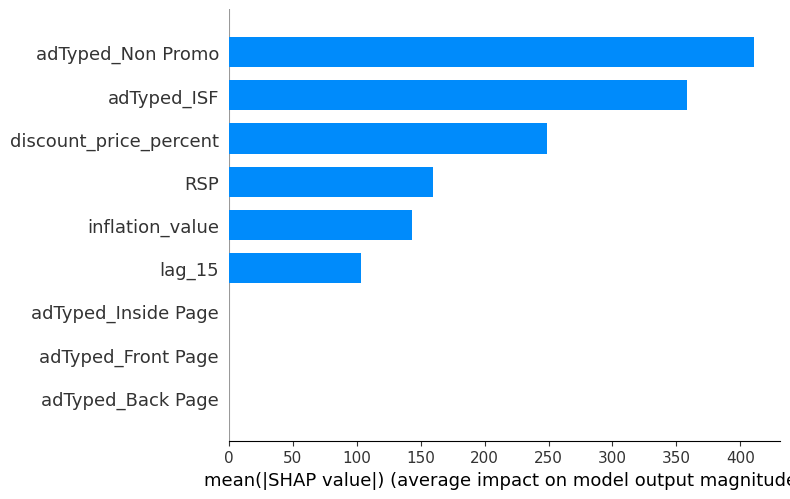

In [0]:
shap.summary_plot(shap_values, X_shp, plot_type="bar")

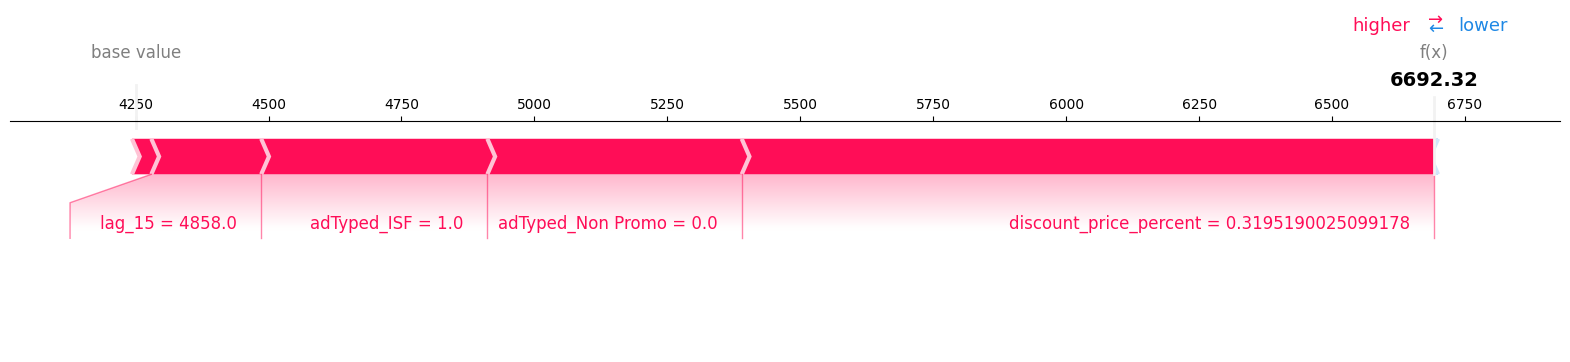

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_shp.iloc[0,:],matplotlib=True)

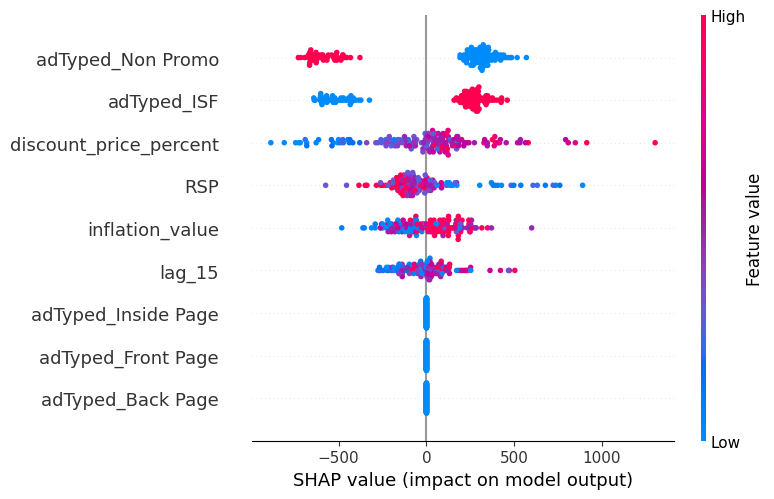

In [0]:
shap.summary_plot(shap_values, X_shp)

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_shp)

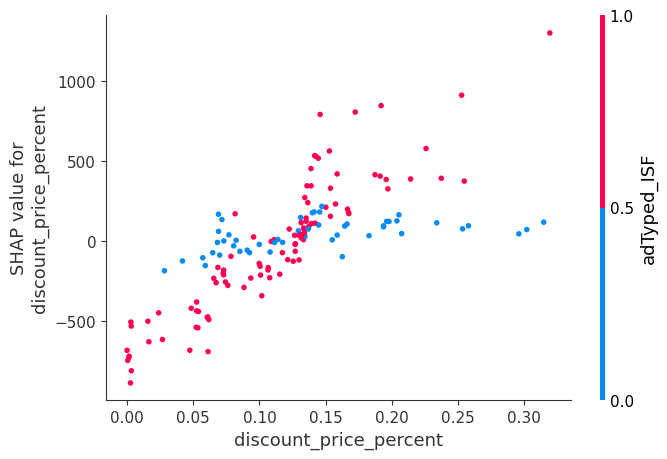

In [0]:
shap.dependence_plot("discount_price_percent", shap_values, X_shp)

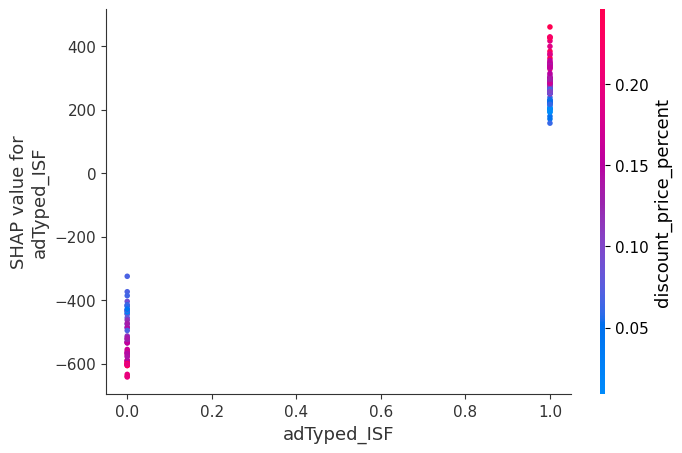

In [0]:
shap.dependence_plot("adTyped_ISF", shap_values, X_shp)

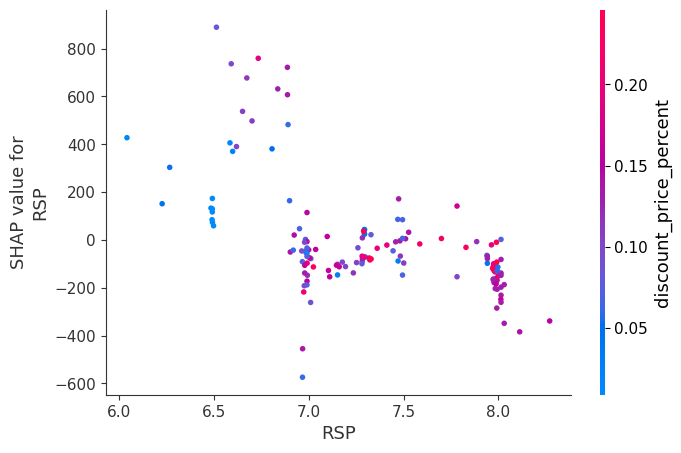

In [0]:
shap.dependence_plot("RSP", shap_values, X_shp)

## Adtyped Post-mortem Analysis

In [0]:
for scope_id in df_train["unique_id"].unique():
    data_ts = df_train[df_train["unique_id"] == scope_id]
    data_ts = data_ts.set_index(time_col)
    data_ts.index.freq = freq
    data_ts = data_ts[x_variable_cols + [target_variable_col]]
    data_ts_raw = data_ts.copy()
    
    forecaster = ForecasterRecursive(
            regressor=CatBoostRegressor(
                random_state=42, 
                allow_writing_files=False,
                ),
            lags=[15],
            transformer_exog = one_hot_encoder
        )

    forecaster.fit(
            y=data_ts[target_variable_col],
            exog=data_ts[x_variable_cols],
        )
    
    # Base Units Past simulation
    exog_past = data_ts[x_variable_cols].copy()
    exog_past["discount_price_percent"] = 0 # Consideration: Non Promo = 0 discount percent
    exog_past["adTyped"] = "Non Promo"

    # We adjust the index of the exog_past dates so that they are in the future (e.g. 1 week after the last day of the window).
    exog_past.index = pd.date_range(
        data_ts.index.max() + pd.Timedelta(weeks=1), 
        periods=len(exog_past), 
        freq=freq)

    # Now that the `exog` index is in the future, we perform the prediction.
    data_ts_raw["base_units"] = forecaster.predict(
        exog=exog_past,
        steps=len(exog_past),
    ).values

    # Postmortem: Adtyped prediction
    promo_activity_df = data_ts[x_variable_cols].copy()
    promo_activity_df.index = pd.date_range(
        data_ts.index.max() + pd.Timedelta(weeks=1), 
        periods=len(exog_past), 
        freq=freq)

    promo_activity_df["adTyped"] = "Front Page"
    data_ts_raw["FP_pred"] = forecaster.predict(
        exog=promo_activity_df,
        steps=len(promo_activity_df),
    ).values
    
    promo_activity_df["adTyped"] = "Inside Page"
    data_ts_raw["IP_pred"] = forecaster.predict(
        exog=promo_activity_df,
        steps=len(promo_activity_df),
    ).values

    promo_activity_df["adTyped"] = "Back Page"
    data_ts_raw["BP_pred"] = forecaster.predict(
        exog=exog_past,
        steps=len(promo_activity_df),
    ).values

    promo_activity_df["adTyped"] = "ISF"
    data_ts_raw["ISF_pred"] = forecaster.predict(
        exog=promo_activity_df,
        steps=len(promo_activity_df),
    ).values
    break

Learning rate set to 0.032162
0:	learn: 2647.1712113	total: 534us	remaining: 534ms
1:	learn: 2591.3508450	total: 1.91ms	remaining: 951ms
2:	learn: 2541.2744436	total: 2.29ms	remaining: 763ms
3:	learn: 2489.8820559	total: 2.74ms	remaining: 683ms
4:	learn: 2435.5423976	total: 2.92ms	remaining: 582ms
5:	learn: 2381.4265581	total: 3.18ms	remaining: 527ms
6:	learn: 2327.1588384	total: 3.55ms	remaining: 504ms
7:	learn: 2279.2812100	total: 3.94ms	remaining: 488ms
8:	learn: 2227.6626555	total: 4.07ms	remaining: 448ms
9:	learn: 2181.4546565	total: 4.16ms	remaining: 412ms
10:	learn: 2137.5927794	total: 4.53ms	remaining: 407ms
11:	learn: 2096.7330937	total: 4.92ms	remaining: 405ms
12:	learn: 2054.6983341	total: 5.27ms	remaining: 400ms
13:	learn: 2017.3084468	total: 5.74ms	remaining: 404ms
14:	learn: 1978.0981170	total: 6.12ms	remaining: 402ms
15:	learn: 1940.0926111	total: 6.47ms	remaining: 398ms
16:	learn: 1902.0599306	total: 6.73ms	remaining: 389ms
17:	learn: 1868.2790210	total: 7.09ms	remainin

In [0]:
# Para fechas donde adTyped != Non Promo, comparar diferencias de Sales en % y en % sobre el base Units
data_ts_raw[data_ts_raw.adTyped != "Non Promo"].round(2) # los adtypes tienen el valor de los base units incorporados.

,RSP,discount_price_percent,adTyped,inflation_value,TL Units,base_units,FP_pred,IP_pred,BP_pred,ISF_pred
Date,,,,,,,,,,
2019-11-16,7.38,0.12,ISF,135.1,9406.0,5032.66,7613.32,8234.33,5032.66,8628.43
2019-12-21,7.37,0.25,ISF,136.4,9287.0,5484.82,9850.95,9911.75,5484.82,11027.65
2020-01-04,7.42,0.26,ISF,136.4,6741.0,4875.84,8695.75,9086.91,4875.84,9762.12
2020-01-18,7.83,0.17,ISF,136.4,7364.0,5323.05,9484.53,10300.98,5323.05,10709.71
2020-01-25,7.88,0.18,ISF,136.4,6114.0,4304.88,8012.92,8990.60,4304.88,9359.43
...,...,...,...,...,...,...,...,...,...,...
2024-02-24,7.15,0.16,ISF,164.9,9317.0,5862.78,8200.99,8867.88,5862.78,9393.46
2024-03-09,6.55,0.04,ISF,166.6,8619.0,5878.53,7671.22,7903.70,5878.53,8901.34
2024-03-23,7.23,0.10,ISF,166.6,10007.0,5851.30,8160.07,8372.09,5851.30,9853.68


# Refit & Model Saving

In [0]:
from skforecast.utils import save_forecaster

# Uplift Model
for scope_id in df_train["unique_id"].unique():
    print(scope_id)
    data_ts = df_train[df_train["unique_id"] == scope_id]
    data_ts = data_ts.set_index(time_col)
    data_ts.index.freq = freq
    data_ts = data_ts[x_variable_cols + [target_variable_col]]
    
    # Train model
    forecaster = ForecasterRecursive(
            regressor=CatBoostRegressor(
                random_state=42, 
                allow_writing_files=False,
                ),
            lags=[15],
            transformer_exog = one_hot_encoder
        )

    forecaster.fit(
            y=data_ts[target_variable_col],
            exog=data_ts[x_variable_cols],
        )
    
    save_forecaster(forecaster, 
                    file_name=f'forecaster_models/{scope_id.replace("/","#")}_forecaster.joblib', 
                    verbose=False)